In [1]:
# imports

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from report_writer import ReportWriter
from utils import get_info

In [2]:

RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

FILE_URL ='https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/compas-scores-two-years.csv'
FILE_NAME = 'compas-scores-two-years.csv'

# file is small, i will not chunk

if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

if not os.path.exists(os.path.join(DATA_FOLDER, FILE_NAME)):
    import urllib.request
    urllib.request.urlretrieve(FILE_URL, os.path.join(DATA_FOLDER, FILE_NAME))

data_file_path = os.path.join(DATA_FOLDER, 'compas-scores-two-years.csv')
df = pd.read_csv(data_file_path)
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (7214, 53)


In [3]:

print(df['decile_score'].describe())

count    7214.000000
mean        4.509565
std         2.856396
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        10.000000
Name: decile_score, dtype: float64


In [3]:
df_reduced = df[['sex', 'two_year_recid', 'decile_score', 'priors_count', 'age_cat', 'race', 'c_charge_degree']]





In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Copy the original dataset
df_encoded = df_reduced.copy()

# onehot encoding
ohe_features = ['sex', 'race', 'c_charge_degree', 'age_cat']

ohe = OneHotEncoder()
df_ohe = pd.DataFrame(ohe.fit_transform(df_encoded[ohe_features]).toarray(), columns=ohe.get_feature_names_out(ohe_features))
df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

df_final = df_encoded[['two_year_recid', 'decile_score', 'priors_count','sex_Female', 'sex_Male', 'race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other'
                      ,'c_charge_degree_M','age_cat_Greater than 45','age_cat_Less than 25']]


#,'decile_score'

final_file_path = os.path.join(DATA_FOLDER, 'final_dataset.csv')
df_final.to_csv(final_file_path, index=False)

In [6]:
import torch

# One-hot encode the decile score
DECILE_LABEL = 'decile_score'

# Ensure column exists and is clean
if DECILE_LABEL not in df_final.columns:
    raise KeyError(f"Column '{DECILE_LABEL}' not found in df_final.")

# Convert to integer if needed
df_final = df_final.astype({DECILE_LABEL: int})

# Prepare the target as class indices (not one-hot encoded)
y = df_final[DECILE_LABEL].values  # Class indices [0, 1, ..., 9]


y_ohe = torch.nn.functional.one_hot(torch.tensor(y), num_classes=11).long()


# Features
X = df_final.drop(columns=[DECILE_LABEL]).values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_ohe, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)  # Class indices (not one-hot encoded)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print(y_ohe[3])
print(y[3])



tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
8


C:\Users\carme\AppData\Local\Temp\ipykernel_27320\1708201397.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float)  # Class indices (not one-hot encoded)
C:\Users\carme\AppData\Local\Temp\ipykernel_27320\1708201397.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.long)


In [8]:
import torch.nn as nn

# Define the new model
# class MultiClassClassifier(nn.Module):
#     def __init__(self, input_size):
#         super(MultiClassClassifier, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 64),
#             # nn.BatchNorm1d(64),
#             nn.LeakyReLU(),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(),
#             nn.Linear(32, 11),  # Output 10 neurons for 10 classes
#             nn.Softmax(dim=1)  # Output probabilities [0, 1] for each class
#         )

#     def forward(self, x):
#         return self.model(x)  # Logits as output

# input_size = X_train.shape[1]  # Number of input features
# model = MultiClassClassifier(input_size)


layers = [
    nn.Linear(11, 64), nn.BatchNorm1d(64), nn.LeakyReLU(),
    nn.Linear(64, 32), nn.LeakyReLU(),  nn.Linear(32, 11),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # for other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, nn.Linear):
            layer.weight *= 1


parameters = [p for layer in layers for p in layer.parameters()]
# total number of parameters
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


3339


In [101]:
# criterion = nn.CrossEntropyLoss()  # Multi-class loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


7489
Epoch [1/5000], Loss: 0.0015 Validation Loss: 0.1468
Epoch [2/5000], Loss: 0.0009 Validation Loss: 0.1147
Epoch [3/5000], Loss: 0.0008 Validation Loss: 0.1011
Epoch [4/5000], Loss: 0.0007 Validation Loss: 0.0929
Epoch [5/5000], Loss: 0.0006 Validation Loss: 0.0868
Epoch [6/5000], Loss: 0.0006 Validation Loss: 0.0820
Epoch [7/5000], Loss: 0.0006 Validation Loss: 0.0780
Epoch [8/5000], Loss: 0.0005 Validation Loss: 0.0746
Epoch [9/5000], Loss: 0.0005 Validation Loss: 0.0718
Epoch [10/5000], Loss: 0.0005 Validation Loss: 0.0694
Epoch [11/5000], Loss: 0.0005 Validation Loss: 0.0674
Epoch [12/5000], Loss: 0.0005 Validation Loss: 0.0656
Epoch [13/5000], Loss: 0.0005 Validation Loss: 0.0641
Epoch [14/5000], Loss: 0.0005 Validation Loss: 0.0629
Epoch [15/5000], Loss: 0.0005 Validation Loss: 0.0618
Epoch [16/5000], Loss: 0.0005 Validation Loss: 0.0608
Epoch [17/5000], Loss: 0.0004 Validation Loss: 0.0600
Epoch [18/5000], Loss: 0.0004 Validation Loss: 0.0593
Epoch [19/5000], Loss: 0.0004 Va

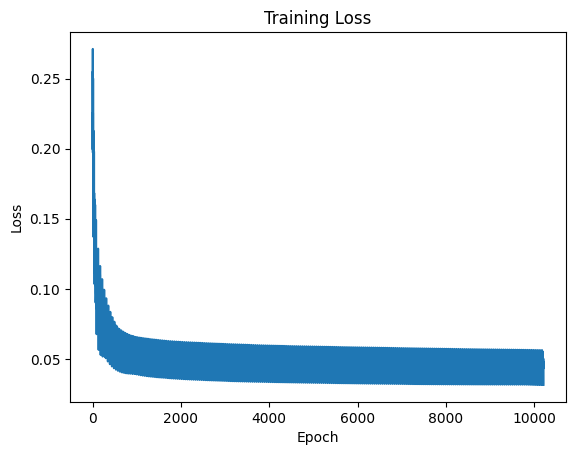

Text(0.5, 1.0, 'Validation Loss')

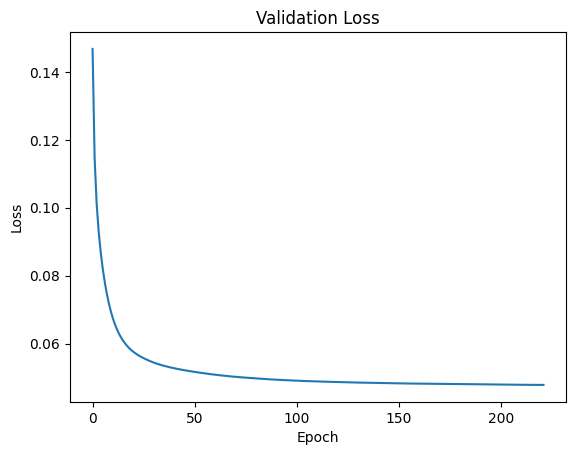

In [104]:
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn


DECILE_LABEL = 'decile_score'

if DECILE_LABEL not in df_final.columns:
    raise KeyError(f"Column '{DECILE_LABEL}' not found in df_final.")

# features
X = df_final.drop(columns=[DECILE_LABEL]).values
# labels, normalize
y = df_final[DECILE_LABEL].values / 10

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# to pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Class indices (not one-hot encoded)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        

layers = [
    nn.Linear(13, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 1),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # for other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, nn.Linear):
            layer.weight *= 1


parameters = [p for layer in layers for p in layer.parameters()]
# total number of parameters

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True



epochs = 5000
batch_size = 128
num_samples = X_train_tensor.size(0)


# Collect all parameters from layers
parameters = [p for layer in layers for p in layer.parameters() if p.requires_grad]


training_losses = []
validation_losses = []

for epoch in range(epochs):
    training_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, num_samples, batch_size):
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        x = X_batch
        for layer in layers:
            x = layer(x)
        
        # Loss calculation
        loss = F.mse_loss(x.squeeze(), y_batch)
        # print(f"Loss: {loss.item()}")

        # Clear gradients (ensure no accumulation of gradients)
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()  # Ensure graph isn't reused accidentally
        
        # for p in parameters:
        #     print(f"Gradient for parameter {p}: {p.grad}")


        learning_rate = 0.001
        # Update weights
        for p in parameters:
            p.data -= learning_rate * p.grad

        # Track epoch loss
        training_loss += loss.item()
        training_losses.append(loss.item())     
    
    # # Validation loss
    with torch.no_grad():
        # Validation loss
        x = X_val_tensor
        for layer in layers:
            x = layer(x)
        val_loss = F.mse_loss(x.squeeze(), y_val_tensor)
        validation_losses.append(val_loss.item())
    
    if epoch > 5 and  abs(validation_losses[-1] - validation_losses[-2]) < 0.000001:
        print(validation_losses[-1] - validation_losses[-2])
        print(f"Early stopping at epoch {epoch+1}, {validation_losses[-1]}, {validation_losses[-2]}")
        break
    
    # training_losses.append(training_loss / num_samples)    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {training_loss/num_samples:.4f}", f"Validation Loss: {val_loss:.4f}")

plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')



                 0
count  1443.000000
mean      0.449686
std       0.190814
min       0.075621
25%       0.294073
50%       0.436834
75%       0.590656
max       1.018424
tensor([0.1199, 0.3476, 0.5163, 0.6360, 0.2132, 0.7488, 0.3512, 0.1401, 0.1969,
        0.3512])
tensor([0.1000, 0.3000, 0.4000, 1.0000, 0.1000, 1.0000, 0.5000, 0.1000, 0.2000,
        0.2000])
tensor(584)
tensor(524)


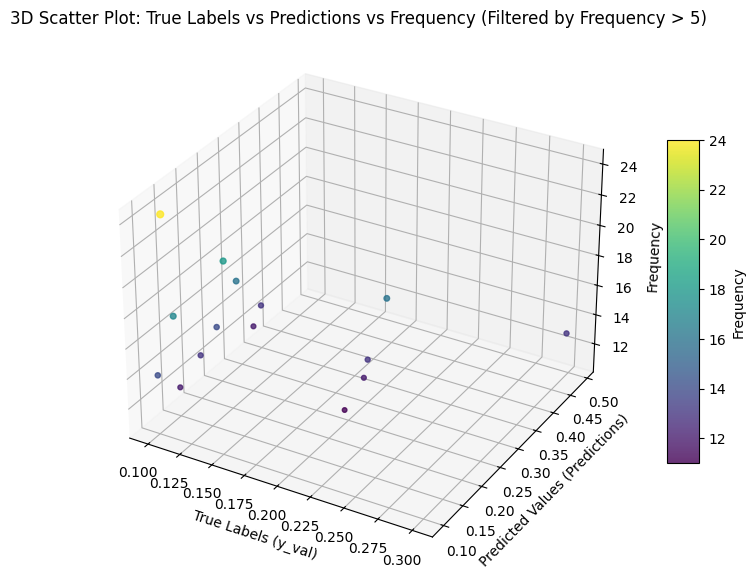

In [105]:
import numpy as np

# Perform predictions on the validation dataset

with torch.no_grad():
    x = X_val_tensor
    for layer in layers:
        x = layer(x)

predictions = x.squeeze()


print(pd.DataFrame(predictions).describe())


print(predictions[0:10])
print(y_val_tensor[0:10])

# print(pd.DataFrame(predictions).describe())   
# print(pd.DataFrame(y_val_tensor).describe())

print(sum(predictions > 0.5))
print(sum(y_val_tensor > 0.5))


# Assuming y_val_tensor and predictions are already computed

# Convert tensors to numpy arrays for processing
y_val_numpy = y_val_tensor.numpy()
predictions_numpy = predictions.numpy()

# Round the predictions to group them for frequency counting
y_val_rounded = np.round(y_val_numpy, decimals=2)
predictions_rounded = np.round(predictions_numpy, decimals=2)

# Count frequency of each (true value, prediction) pair
pair_counts = Counter(zip(y_val_rounded, predictions_rounded))

# Extract unique x, y values and corresponding frequencies (apply frequency filter > 5)
x_vals = []
y_vals = []
frequencies = []

for (y_val, pred_val), freq in pair_counts.items():
    if freq > 10:  # Apply filter
        x_vals.append(y_val)
        y_vals.append(pred_val)
        frequencies.append(freq)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the frequencies as z-values
scatter = ax.scatter(x_vals, y_vals, frequencies, c=frequencies, cmap='viridis', s=frequencies, alpha=0.8)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Frequency')

# Set axis labels
ax.set_xlabel("True Labels (y_val)")
ax.set_ylabel("Predicted Values (Predictions)")
ax.set_zlabel("Frequency")
ax.set_title("3D Scatter Plot: True Labels vs Predictions vs Frequency (Filtered by Frequency > 5)")

plt.show()


# # Iterate through thresholds and calculate ranges
# step = 0.1
# thresholds = np.arange(0, 1, step)  # [0.0, 0.1, ..., 0.9]

# print("Threshold | Min Value | Max Value")
# print("----------------------------------")

# for threshold in thresholds:
#     # Select predictions within the range [threshold, threshold + step)
#     mask = (predictions >= threshold) & (predictions < threshold + step)
#     filtered_predictions = predictions[mask]

#     # Compute the smallest and largest predictions in the range
#     if filtered_predictions.numel() > 0:  # Check if there are any values in the range
#         min_value = torch.min(filtered_predictions).item()
#         max_value = torch.max(filtered_predictions).item()
#     else:
#         min_value = None
#         max_value = None

#     print(f"{threshold:.1f} - {threshold + step:.1f} | {min_value} | {max_value}")


In [ ]:
model.eval()
with torch.no_grad():
    probs = model(X_val_tensor)  # Raw logits
    val_loss = criterion(probs, y_val_tensor)  # Compute validation loss
    _, predictions = torch.max(probs, 1)  # Predicted classes
    val_accuracy = (predictions == y_val_tensor).float().mean().item()  # Validation accuracy

print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")


RuntimeError: Expected floating point type for target with class probabilities, got Long

In [ ]:
print(predictions)
print(y_val_tensor)

print(sum(predictions == y_val_tensor).item())
print(len(y_val_tensor))







print(probs)


tensor([1, 2, 4,  ..., 1, 2, 4])
tensor([ 1,  3,  4,  ...,  1,  3, 10])
389
1443
406
524
tensor([[6.5506e-16, 9.9997e-01, 3.4689e-05,  ..., 2.5432e-25, 1.0176e-31,
         7.7183e-16],
        [3.8818e-08, 4.0147e-01, 5.9655e-01,  ..., 3.5805e-12, 1.6061e-15,
         4.6751e-08],
        [2.7078e-09, 3.3193e-06, 2.3187e-03,  ..., 7.2131e-04, 2.3457e-07,
         5.5984e-09],
        ...,
        [1.9121e-08, 8.5564e-01, 1.4406e-01,  ..., 1.6449e-12, 2.2408e-16,
         2.2360e-08],
        [1.1356e-05, 1.3056e-01, 5.7045e-01,  ..., 1.0029e-05, 1.0220e-08,
         1.4981e-05],
        [2.1255e-06, 7.1389e-07, 1.3693e-03,  ..., 1.2796e-02, 1.5600e-04,
         3.1664e-06]])


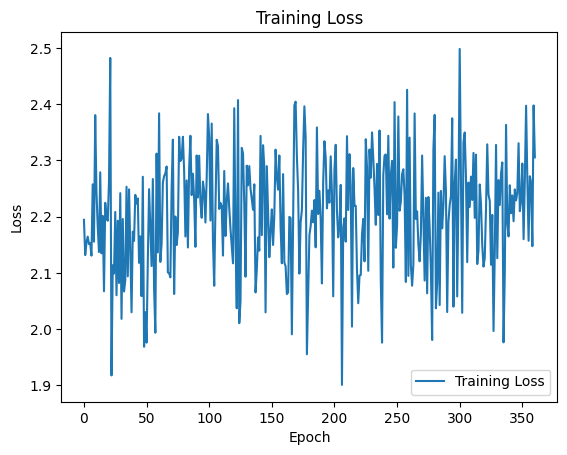

In [94]:
import matplotlib.pyplot as plt

# Assuming `losses` and `accuracies` are recorded during training
plt.plot(losses, label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plt.plot(accuracies, label="Training Accuracy")
# plt.title("Training Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()
